In [1]:
import torch
import matplotlib.pyplot as plt
from embed_time.dataloader_rs import LiveTLSDataset
from embed_time.model import VAE
from embed_time.UNet_based_encoder_decoder import UNetDecoder, UNetEncoder
import torch
from torch.utils.data import DataLoader
from torch.nn import functional as F
from tqdm import tqdm
from pathlib import Path
import os
import skimage.io as io
import torchvision.transforms as trans
from torchvision.transforms import v2
from embed_time.transforms import CustomToTensor, SelectRandomTPNumpy, CustomCropCentroid
from embed_time.dataloader_rs import LiveTLSDataset
from datetime import datetime

base_dir = "/mnt/efs/dlmbl/G-et/checkpoints/time-series"
checkpoint_dir = Path(base_dir) / f"{datetime.today().strftime('%Y-%m-%d')}_UNEt_encdec_checkpoints"
print(checkpoint_dir)

checkpoint_dir.mkdir(exist_ok=True)
data_location = "/mnt/efs/dlmbl/G-et/data/live-TLS"
folder_imgs = data_location +"/"+'Control_Dataset_4TP_Normalized'
metadata = data_location + "/" +'Control_Dataset_4TP_Ground_Truth'

loading_transforms_test = trans.Compose([
    SelectRandomTPNumpy(0),
    CustomCropCentroid(0,0,598),
    CustomToTensor(),
    v2.Resize((576,576)),
    #v2.RandomAffine(
    #    degrees=90,
    #    translate=[0.1,0.1],
    #),
    #v2.RandomHorizontalFlip(),
    #v2.RandomVerticalFlip(),
    #v2.GaussianNoise(0,0.05)
])

dataset_w_t = LiveTLSDataset(
    metadata,
    folder_imgs,
    metadata_columns=["Run","Plate","ID"],
    return_metadata=False,
    transform = loading_transforms_test,
)

sample, label = dataset_w_t[0]
in_channels, y, x = sample.shape
print(in_channels)
print((y,x))

NUM_EPOCHS = 50
encoder = UNetEncoder(
    in_channels = in_channels,
    n_fmaps = 8,
    depth = 3,
    in_spatial_shape = (y,x),
    z_dim = 20,
)

decoder = UNetDecoder(
    in_channels = in_channels,
    n_fmaps = 8,
    depth = 3,
    in_spatial_shape = (y,x),
    z_dim = 20,
    upsample_mode="nearest"
)

model = VAE(encoder, decoder)
dataloader = DataLoader(dataset_w_t, batch_size=4, shuffle=True, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


/mnt/efs/dlmbl/G-et/checkpoints/time-series/2024-08-31_UNEt_encdec_checkpoints
2
(576, 576)


VAE(
  (encoder): UNetEncoder(
    (downsample): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (convs): ModuleList(
      (0): ConvBlock(
        (conv_pass): Sequential(
          (0): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (1): ConvBlock(
        (conv_pass): Sequential(
          (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
      (2): ConvBlock(
        (conv_pass): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (1): ReLU()
          (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
          (3): ReLU()
        )
      )
    )
    (fc1): Linear(in_feat

In [2]:
os.listdir(checkpoint_dir)

['checkpoint_25.pth',
 'checkpoint_7.pth',
 'checkpoint_43.pth',
 'checkpoint_34.pth',
 'checkpoint_16.pth',
 'checkpoint_21.pth',
 'checkpoint_3.pth',
 'checkpoint_30.pth',
 'checkpoint_12.pth',
 'checkpoint_29.pth',
 'checkpoint_47.pth',
 'checkpoint_38.pth',
 'checkpoint_1.pth',
 'checkpoint_10.pth',
 'checkpoint_27.pth',
 'checkpoint_9.pth',
 'checkpoint_45.pth',
 'checkpoint_36.pth',
 'checkpoint_18.pth',
 'checkpoint_23.pth',
 'checkpoint_5.pth',
 'checkpoint_41.pth',
 'checkpoint_32.pth',
 'checkpoint_14.pth',
 'checkpoint_49.pth',
 'checkpoint_0.pth',
 'checkpoint_8.pth',
 'checkpoint_26.pth',
 'checkpoint_44.pth',
 'checkpoint_35.pth',
 'checkpoint_17.pth',
 'checkpoint_4.pth',
 'checkpoint_22.pth',
 'checkpoint_40.pth',
 'checkpoint_31.pth',
 'checkpoint_13.pth',
 'checkpoint_48.pth',
 'checkpoint_39.pth',
 'checkpoint_2.pth',
 'checkpoint_20.pth',
 'checkpoint_11.pth',
 'checkpoint_28.pth',
 'checkpoint_46.pth',
 'checkpoint_37.pth',
 'checkpoint_19.pth',
 'checkpoint_6.pth'

In [4]:
dict = torch.load(checkpoint_dir/'checkpoint_49.pth')
dict.keys()

/tmp/ipykernel_106523/158696822.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(checkpoint_dir/'checkpoint_49.pth')


dict_keys(['model', 'optimizer', 'epoch'])

In [5]:
model_params = dict['model']
model.load_state_dict(model_params)

<All keys matched successfully>

In [43]:
dataloader = DataLoader(dataset_w_t, batch_size=1, shuffle=False, pin_memory=True)

for i,first in enumerate(dataloader):
    if i == 50:
        test_image = first[0]
        break

test_image.squeeze(0).shape

torch.Size([2, 576, 576])

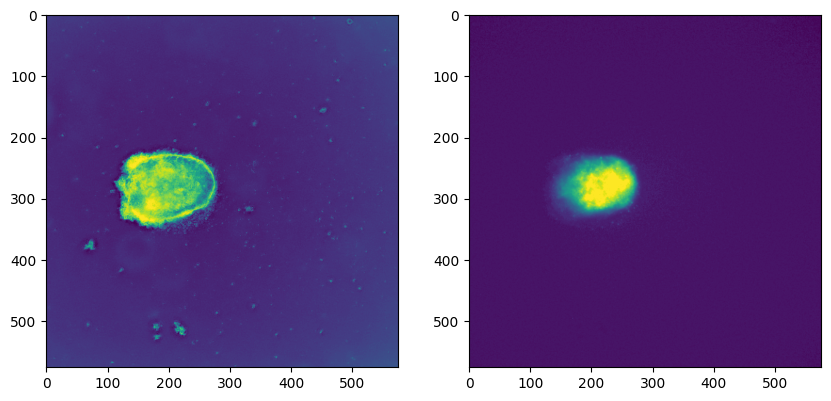

In [44]:
plot_size = 5
plot_images = 2
fig, ax = plt.subplots(1,plot_images,figsize=(plot_images*plot_size,plot_size))

ax[0].imshow(test_image.squeeze(0).numpy()[0])
ax[1].imshow(test_image.squeeze(0).numpy()[1])

In [45]:
model.eval()
result = model(test_image.to(device))[0]
result.shape

torch.Size([1, 2, 576, 576])

In [46]:
result = result.detach().cpu().squeeze().numpy()
result.shape

(2, 576, 576)

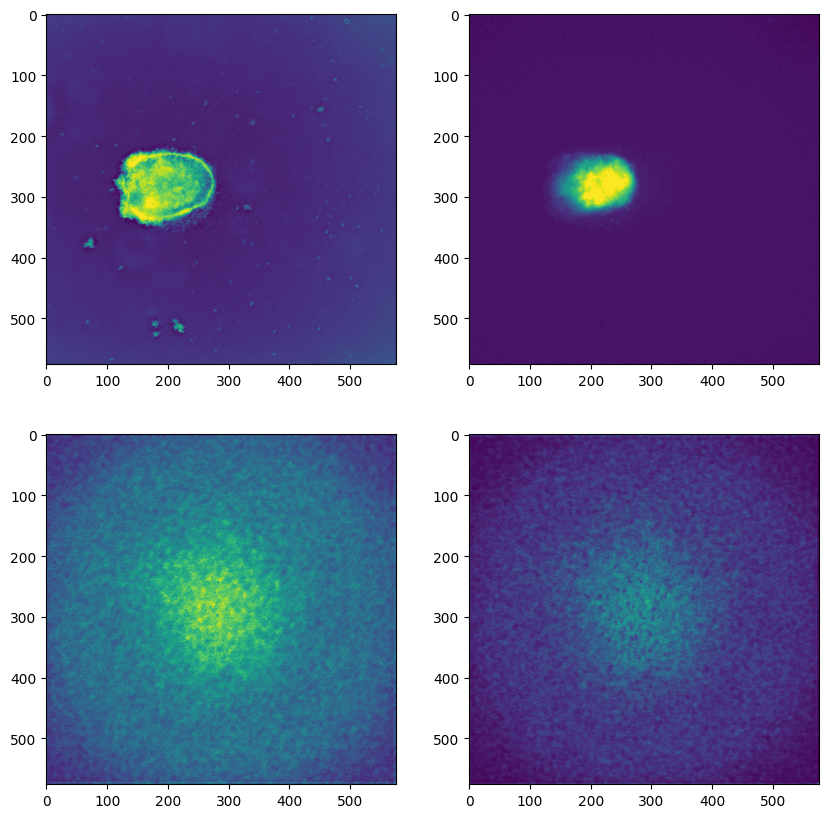

In [47]:
fig, ax = plt.subplots(2,2,figsize=(2*plot_size,2*plot_size))

ax[0,0].imshow(test_image.squeeze(0).numpy()[0])
ax[0,1].imshow(test_image.squeeze(0).numpy()[1])
ax[1,0].imshow(result[0])
ax[1,1].imshow(result[1])

In [49]:
checkpoints_ian = '/mnt/efs/dlmbl/G-et/checkpoints/time-series/2024-08-31_UNEt_encdec_02_checkpoints'
dict = torch.load(Path(checkpoints_ian)/'checkpoint_49.pth')
dict.keys()

/tmp/ipykernel_106523/647816853.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dict = torch.load(Path(checkpoints_ian)/'checkpoint_49.pth')


dict_keys(['model', 'optimizer', 'epoch'])

In [50]:
model_params = dict['model']
model.load_state_dict(model_params)

RuntimeError: Error(s) in loading state_dict for VAE:
	Unexpected key(s) in state_dict: "encoder.convs.3.conv_pass.0.weight", "encoder.convs.3.conv_pass.0.bias", "encoder.convs.3.conv_pass.2.weight", "encoder.convs.3.conv_pass.2.bias", "decoder.convs.3.conv_pass.0.weight", "decoder.convs.3.conv_pass.0.bias", "decoder.convs.3.conv_pass.2.weight", "decoder.convs.3.conv_pass.2.bias". 
	size mismatch for encoder.convs.0.conv_pass.0.weight: copying a param with shape torch.Size([10, 2, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 2, 3, 3]).
	size mismatch for encoder.convs.0.conv_pass.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for encoder.convs.0.conv_pass.2.weight: copying a param with shape torch.Size([10, 10, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for encoder.convs.0.conv_pass.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for encoder.convs.1.conv_pass.0.weight: copying a param with shape torch.Size([20, 10, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 8, 3, 3]).
	size mismatch for encoder.convs.1.conv_pass.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.convs.1.conv_pass.2.weight: copying a param with shape torch.Size([20, 20, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for encoder.convs.1.conv_pass.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.convs.2.conv_pass.0.weight: copying a param with shape torch.Size([40, 20, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 16, 3, 3]).
	size mismatch for encoder.convs.2.conv_pass.0.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.convs.2.conv_pass.2.weight: copying a param with shape torch.Size([40, 40, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 32, 3, 3]).
	size mismatch for encoder.convs.2.conv_pass.2.bias: copying a param with shape torch.Size([40]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for encoder.fc1.weight: copying a param with shape torch.Size([25, 414720]) from checkpoint, the shape in current model is torch.Size([20, 663552]).
	size mismatch for encoder.fc1.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for encoder.fc2.weight: copying a param with shape torch.Size([25, 414720]) from checkpoint, the shape in current model is torch.Size([20, 663552]).
	size mismatch for encoder.fc2.bias: copying a param with shape torch.Size([25]) from checkpoint, the shape in current model is torch.Size([20]).
	size mismatch for decoder.convs.0.conv_pass.0.weight: copying a param with shape torch.Size([2, 10, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 8, 3, 3]).
	size mismatch for decoder.convs.1.conv_pass.0.weight: copying a param with shape torch.Size([10, 20, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 16, 3, 3]).
	size mismatch for decoder.convs.1.conv_pass.0.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for decoder.convs.1.conv_pass.2.weight: copying a param with shape torch.Size([10, 10, 3, 3]) from checkpoint, the shape in current model is torch.Size([8, 8, 3, 3]).
	size mismatch for decoder.convs.1.conv_pass.2.bias: copying a param with shape torch.Size([10]) from checkpoint, the shape in current model is torch.Size([8]).
	size mismatch for decoder.convs.2.conv_pass.0.weight: copying a param with shape torch.Size([20, 40, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 32, 3, 3]).
	size mismatch for decoder.convs.2.conv_pass.0.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.convs.2.conv_pass.2.weight: copying a param with shape torch.Size([20, 20, 3, 3]) from checkpoint, the shape in current model is torch.Size([16, 16, 3, 3]).
	size mismatch for decoder.convs.2.conv_pass.2.bias: copying a param with shape torch.Size([20]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.fc1.weight: copying a param with shape torch.Size([414720, 25]) from checkpoint, the shape in current model is torch.Size([663552, 20]).
	size mismatch for decoder.fc1.bias: copying a param with shape torch.Size([414720]) from checkpoint, the shape in current model is torch.Size([663552]).
	size mismatch for decoder.final_conv.0.weight: copying a param with shape torch.Size([2, 10, 3, 3]) from checkpoint, the shape in current model is torch.Size([2, 8, 3, 3]).